In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(directory=DATA_DIR, ext=ext, setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28357/28357 [00:03<00:00, 7449.31it/s]


In [4]:
dfs.df.label.value_counts()

wmv         5285
v           5204
c           4571
sw          2532
t           2386
bl          2332
m           1547
k           1082
wrl         1016
sp           795
wswl         682
grv          239
v(cy)        189
bv           163
w            144
st           104
gv            66
lhb           10
ONBEKEND       9
sl             1
Name: label, dtype: int64

In [6]:
dfs.df.label = dfs.df.label.apply(lambda x: 'v' if x=='v(cy)' else x)
dfs.df.label = dfs.df.label.apply(lambda x: 'v' if x=='bv' else x)
insects = ['v', 'wmv', 'c', 'sw', 't', 'bl', 'm', 'k', 'wrl', 'sp', 'wswl','other']
dfs.df.label = dfs.df.label.apply(lambda x: 'other' if x not in insects else x)
dfs.df = dfs.df[dfs.df.label.isin(insects)]
dfs.df = dfs.df[~dfs.df['label'].isin(['st','vuil'])]
dfs.df.reset_index(drop=True, inplace=True)
dfs.df.label.value_counts()

v        5556
wmv      5285
c        4571
sw       2532
t        2386
bl       2332
m        1547
k        1082
wrl      1016
sp        795
wswl      682
other     573
Name: label, dtype: int64

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.61it/s]


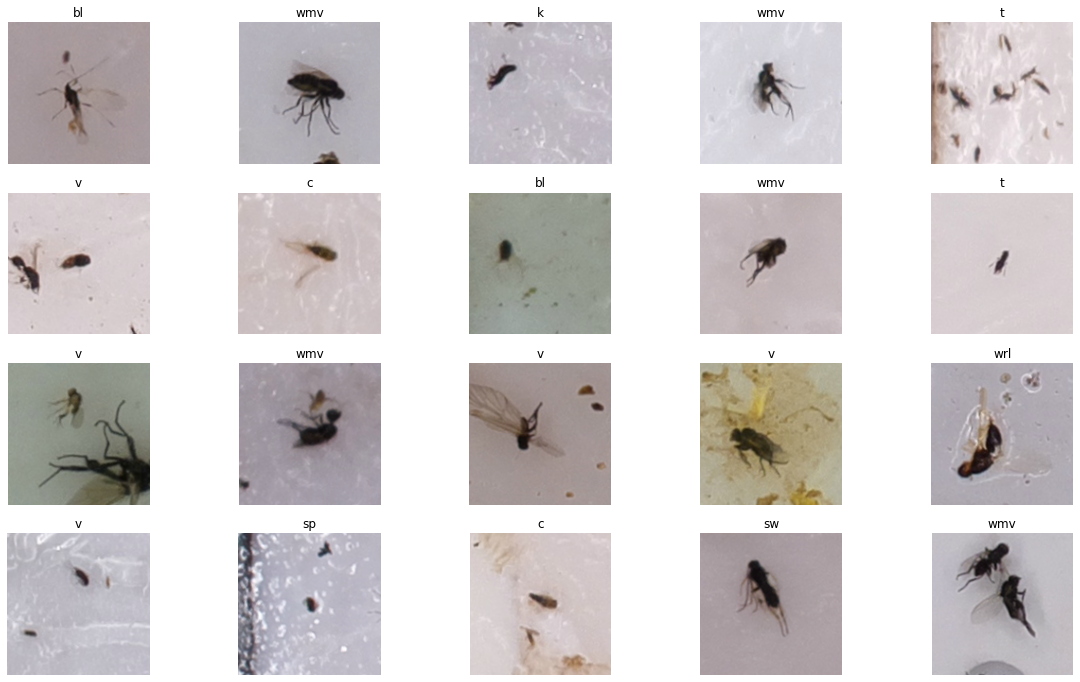

In [7]:
dfs.plot_samples()

# Extra feature collection

In [8]:
batch_size=64
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [9]:
import torch.nn as nn
import torchvision.transforms.functional as fn

n_modelfeats = 512
model = model_selector('densenet121', pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                        nn.Linear(num_ftrs,n_modelfeats))
model.eval()
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
l_blur_factors = [0]*len(dfs)
l_meansRGB = [0]*len(dfs)
l_stdsRGB = [0]*len(dfs)
l_nb_contours, l_mean_cnt_area, l_mean_cnt_perimeter, l_std_cnt_area, l_std_cnt_perimeter = [0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs)
m_feats = np.zeros((len(dfs),n_modelfeats))

c=0
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for i,f in enumerate(filename):
        tmp = fn.to_tensor(fn.to_pil_image(x[i].squeeze()))
        with torch.no_grad():
            model_features = model(torch.unsqueeze(tmp,0)).numpy().squeeze()
        m_feats[c] = model_features
        meanRGB, stdRGB = calc_mean_RGB_vals(f)
        nb_contours, mean_cnt_area, mean_cnt_perimeter, std_cnt_area, std_cnt_perimeter = calc_contour_features(f)
        l_blur_factors[c] = calc_variance_of_laplacian(f)
        l_meansRGB[c] = meanRGB
        l_stdsRGB[c] = stdRGB
        l_nb_contours[c] = nb_contours
        l_mean_cnt_area[c] = mean_cnt_area
        l_mean_cnt_perimeter[c] = mean_cnt_perimeter
        l_std_cnt_area[c] = std_cnt_area
        l_std_cnt_perimeter[c] = std_cnt_perimeter
        c+=1

  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
df_modelfeats = pd.DataFrame(m_feats)
df_modelfeats.columns = [f"feat_{i}" for i in range(n_modelfeats)]

df_rgb = pd.DataFrame(l_meansRGB, columns=['R','G','B'])
df_feats = pd.DataFrame({'blur': l_blur_factors, 
                        'nb_contours': l_nb_contours,
                        'mean_cnt_area': l_mean_cnt_area,
                        'mean_cnt_perimeter': l_mean_cnt_perimeter,
                        'std_cnt_area': l_std_cnt_area,
                        'std_cnt_perimeter': l_std_cnt_perimeter})
df_feats = pd.concat([df_feats, df_rgb], axis=1)
feature_columns = df_feats.columns


df = pd.concat([dfs.df, df_feats], axis=1)
df = pd.concat([df,df_modelfeats],axis=1)
df.sort_values(by='label', inplace=True)

df = df[~df.label.isin(['gv','sl'])]

insect_classes = df.label.unique().tolist()

df

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,feat_502,feat_503,feat_504,feat_505,feat_506,feat_507,feat_508,feat_509,feat_510,feat_511
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,25928,25.307896,...,-0.495594,0.912960,0.063984,-0.232709,-0.479560,-0.174994,-0.326654,-0.252981,0.358149,0.138774
1551,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19077,38.281333,...,-0.187601,0.821072,0.526164,-0.469793,-0.426632,0.419520,-0.815518,0.026786,0.648741,-0.354858
1552,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19078,36.578387,...,-0.382668,0.743512,0.263671,-0.090319,-0.261007,0.420692,-0.200591,0.109152,0.187064,-0.019960
1553,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19087,32.577184,...,-0.473758,0.647597,0.295749,-0.076091,-0.507130,0.224587,-0.532197,-0.485371,0.320631,-0.223352
1554,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19088,38.178309,...,-0.847302,1.356863,0.320086,0.016810,-0.689427,0.659130,-0.627454,-0.576819,0.447900,-0.293586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27904,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1142,27.707360,...,-0.790058,0.939882,0.243992,0.127177,-0.189175,0.907537,-0.203501,-0.267096,-0.214983,-0.500039
27905,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1143,21.642555,...,-0.702077,0.680684,0.350424,-0.019027,-0.344062,0.818961,-0.576424,-0.252383,0.186232,-0.097270
27906,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1144,21.871509,...,-0.644466,0.596788,1.237943,0.668765,-1.438351,1.399692,-0.375294,-0.351510,-0.342389,0.000850
27898,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_a_w37_4056x3040.png_ws...,UNDISTORTED_landen_a_w37_4056x3040.png,2021,landen,w37,a,245,26.093995,...,-0.358106,0.827486,0.351252,-0.114464,-0.757807,0.846525,-0.407885,0.604511,-0.062223,-0.510970


# Outlier detection

### Performed per insect class

In [59]:
l_outlier_features = df_modelfeats.columns.tolist() + ['blur', 'R','G','B', 'nb_contours']#, 'mean_cnt_area', 'mean_cnt_perimeter', 'std_cnt_area', 'std_cnt_perimeter']

def class_outliers(df, features, insect='bl'):
    df = df[df.label==insect]
    outlier, outlier_score = detect_outliers(df[features].fillna(0).values, algorithm='KNN')    
    return outlier, outlier_score

df['knn_outlier'], df['knn_outlier_score'] = 0,0
outliers, scores = [],[]
for ins in tqdm(insect_classes, total=len(insect_classes)):
    out, scr = class_outliers(df, l_outlier_features, insect=ins)
    assert len(out) == df[df.label==ins].shape[0]
    outliers.extend(out)
    scores.extend(scr)
    
df['knn_outlier'], df['knn_outlier_score'] = outliers, scores

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.53it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 54.02it/s]


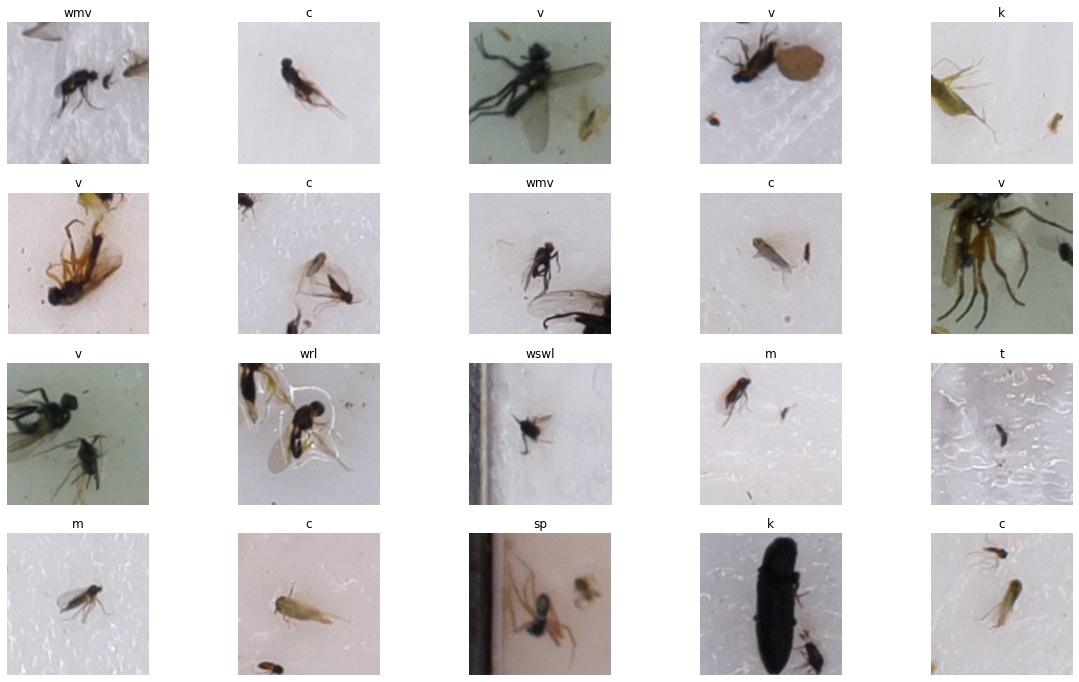

In [60]:
dfs.plot_samples(df[df.knn_outlier==1].sample(20))

In [61]:
print(f"Total of {df[df.knn_outlier==1].shape[0]} outliers found. (# of all datapoints: {df.shape[0]})")
df[df.knn_outlier==1].label.value_counts()

Total of 2842 outliers found. (# of all datapoints: 28357)


v        556
wmv      529
c        457
sw       254
t        239
bl       234
m        155
k        109
wrl      102
sp        80
wswl      69
other     58
Name: label, dtype: int64

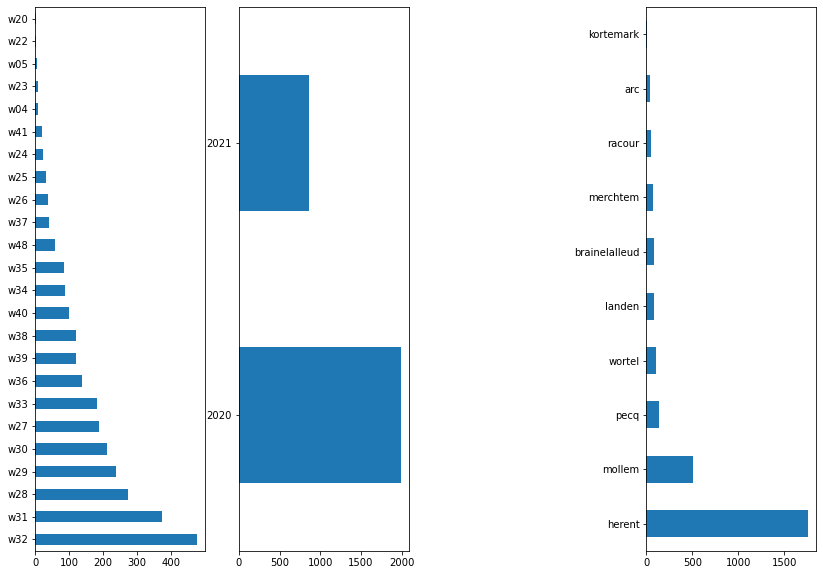

In [15]:
plt.figure(figsize=(24,12))
plt.subplot(1,4,1);
df[df.knn_outlier==1].date.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,2);
df[df.knn_outlier==1].year.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,4);
df[df.knn_outlier==1].location.value_counts().plot(kind='barh', figsize=(14,10));

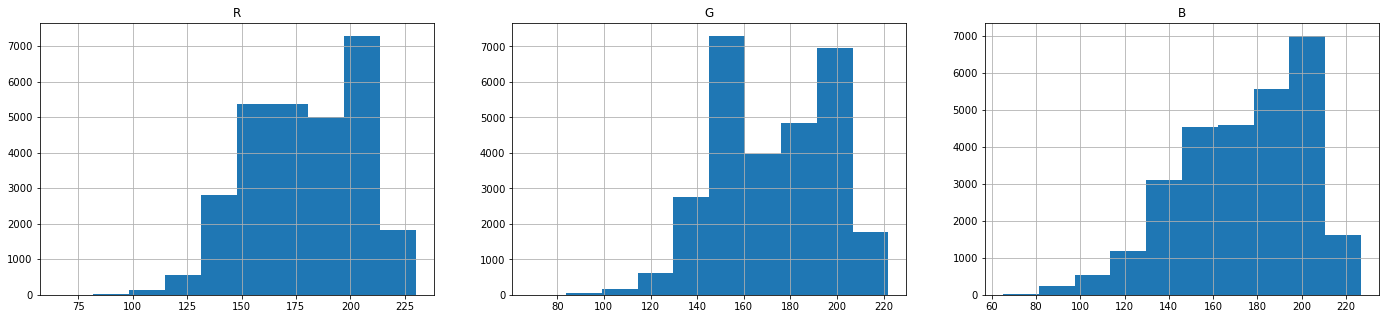

In [16]:
plt.figure(figsize=(24,5))
plt.subplot(1,3,1);
df.R.hist();plt.title('R')
plt.subplot(1,3,2);
df.G.hist();plt.title('G')
plt.subplot(1,3,3);
df.B.hist();plt.title('B');

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 70.46it/s]


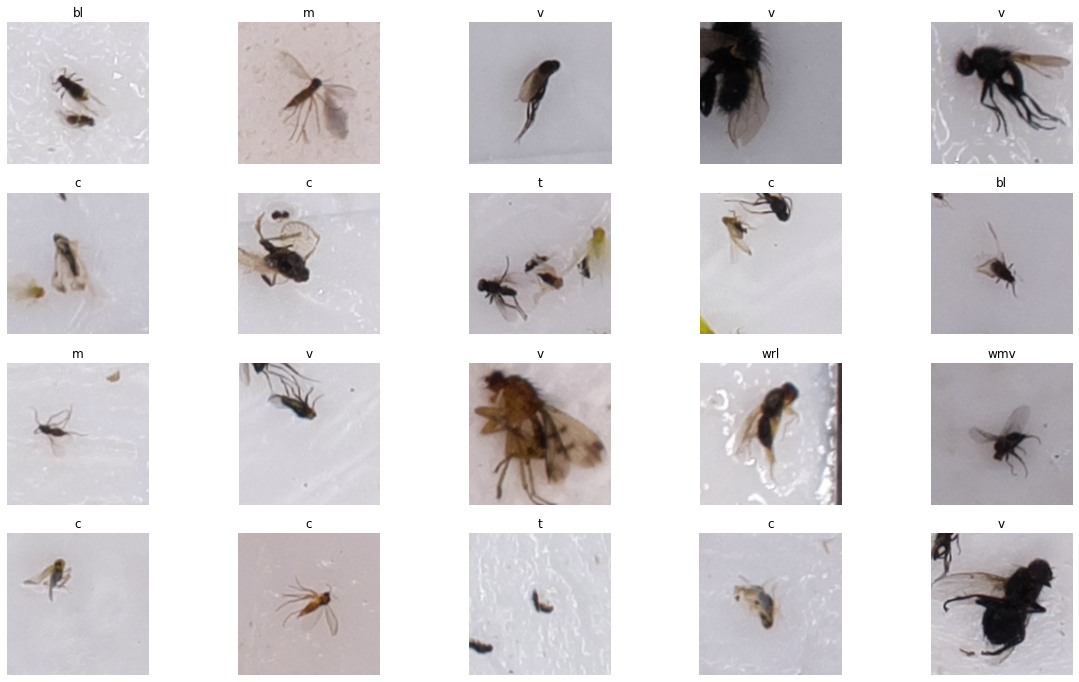

In [17]:
selection = 'knn_outlier==1'
# selection = 'knn_outlier==1 & label==\'wmv\''
dfs.plot_samples(df.query(selection).sample(20))

In [18]:
df.query(selection).date.value_counts()

w32    475
w31    374
w28    272
w29    238
w30    212
w27    189
w33    183
w36    139
w39    121
w38    121
w40    100
w34     88
w35     86
w48     58
w37     42
w26     38
w25     33
w24     23
w41     19
w04     10
w23     10
w05      7
w22      2
w20      2
Name: date, dtype: int64

In [23]:
df

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,feat_504,feat_505,feat_506,feat_507,feat_508,feat_509,feat_510,feat_511,knn_outlier,knn_outlier_score
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,25928,25.307896,...,0.063984,-0.232709,-0.479560,-0.174994,-0.326654,-0.252981,0.358149,0.138774,0,10.154121
1551,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19077,38.281333,...,0.526164,-0.469793,-0.426632,0.419520,-0.815518,0.026786,0.648741,-0.354858,0,26.111742
1552,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19078,36.578387,...,0.263671,-0.090319,-0.261007,0.420692,-0.200591,0.109152,0.187064,-0.019960,0,18.094557
1553,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19087,32.577184,...,0.295749,-0.076091,-0.507130,0.224587,-0.532197,-0.485371,0.320631,-0.223352,0,16.932927
1554,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_herent_w29_2-60_4056x3040_20200703 92710....,herent_w29_2-60_4056x3040_20200703 92710.jpg,2020,herent,w29,2-60,19088,38.178309,...,0.320086,0.016810,-0.689427,0.659130,-0.627454,-0.576819,0.447900,-0.293586,0,18.837984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27904,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1142,27.707360,...,0.243992,0.127177,-0.189175,0.907537,-0.203501,-0.267096,-0.214983,-0.500039,0,19.043664
27905,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1143,21.642555,...,0.350424,-0.019027,-0.344062,0.818961,-0.576424,-0.252383,0.186232,-0.097270,0,19.440243
27906,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1144,21.871509,...,1.237943,0.668765,-1.438351,1.399692,-0.375294,-0.351510,-0.342389,0.000850,1,28.015399
27898,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_a_w37_4056x3040.png_ws...,UNDISTORTED_landen_a_w37_4056x3040.png,2021,landen,w37,a,245,26.093995,...,0.351252,-0.114464,-0.757807,0.846525,-0.407885,0.604511,-0.062223,-0.510970,0,24.024217


# CALCULAE IF INSECT IS CLOSER TO THE EDGE OF FOTO

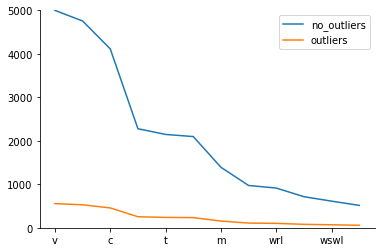

In [49]:
import seaborn as sns
df_all[df_all.knn_outlier==0].label.value_counts().plot()
df_all[df_all.knn_outlier==1].label.value_counts().plot()
plt.legend(['no_outliers','outliers'])
plt.ylim(0,5000);
sns.despine()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 76.17it/s]


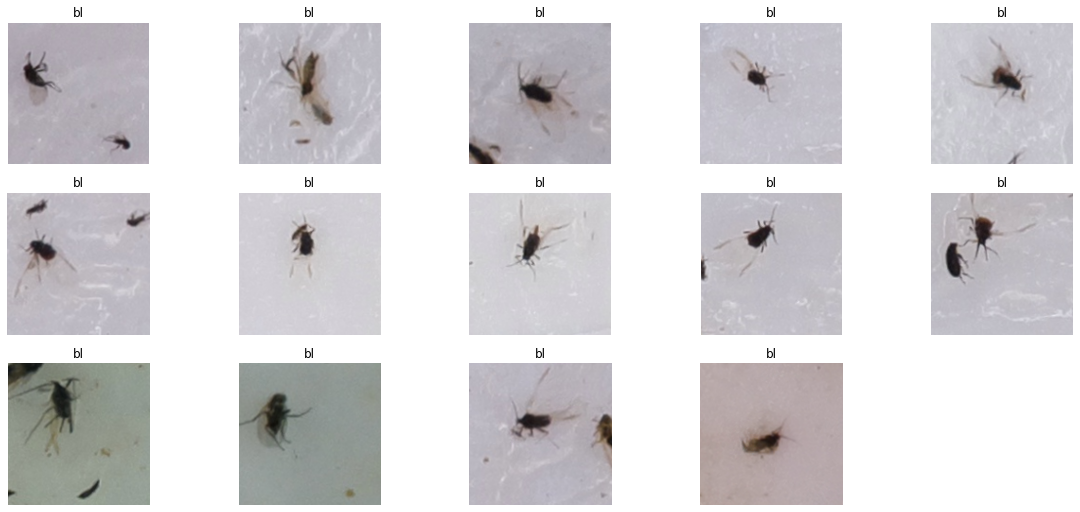

In [50]:
plot_samples(df_all[df_all.knn_outlier==1])

In [20]:
df['plate_idx'] = df['plate_idx'].astype('int64')
df['year'] = df['year'].astype('int64')

df_allinfo = pd.read_csv("../stickybugs/modelling/df_allinfo.csv", index_col='Unnamed: 0')
# df_allinfo['plate_idx'] = df_allinfo.index.values

In [32]:
if setting == 'photobox':
    df_all = df # TODO : IGNORED EDGES NOW ##pd.merge(left=df, right=df_allinfo, on=['plate_idx','platename','year'])
    # assert df_all[df_all.date.apply(lambda x: not x.startswith('w'))].location.unique()[0] == 'wortel', "There are dates not starting with w that are not wortel."
    df_all['date'] = df_all['date'].apply(lambda x: x.replace(x,'w00') if not x.startswith('w') else x)
    print(df_allinfo.year.value_counts())
    print(df.year.value_counts())
    print(df_all.date.value_counts())
    df_all.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')
elif setting=='fuji':
    df.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')

2020    19539
2021    11086
Name: year, dtype: int64
2020    19547
2021     8810
Name: year, dtype: int64
w32    3935
w31    3501
w27    3041
w28    2312
w29    2203
w30    2104
w33    2075
w36    1280
w26    1096
w38     989
w35     942
w34     933
w40     823
w39     762
w48     595
w24     450
w37     423
w25     396
w23     198
w41     157
w20      49
w04      42
w22      35
w05      15
w21       1
Name: date, dtype: int64


In [37]:
import os
os.listdir(SAVE_DIR)

['efficientnetb1_photobox.pth.tar',
 'densenet121_photobox.pth.tar',
 'densenet121_photobox_best.pth.tar',
 'densenet169_photobox.pth.tar',
 'densenet169_photobox_best.pth.tar',
 'df_preparation_fuji.parquet',
 'df_preparation_photobox.parquet',
 'df_test_fuji.parquet',
 'df_test_photobox.parquet',
 'df_train_fuji.parquet',
 'df_train_photobox.parquet',
 'df_val_fuji.parquet',
 'df_val_photobox.parquet',
 'efficientnetb0_photobox.pth.tar',
 'efficientnetb0_photobox_best.pth.tar',
 'efficientnetb1_photobox_best.pth.tar',
 'mobilenetv2_photobox.pth.tar',
 'mobilenetv2_photobox_best.pth.tar',
 'mobilenetv3l_photobox.pth.tar',
 'mobilenetv3l_photobox_best.pth.tar',
 'resnet101_photobox.pth.tar',
 'resnet101_photobox_best.pth.tar',
 'resnet50_photobox.pth.tar',
 'resnet50_photobox_best.pth.tar',
 'vgg16_fuji.pth.tar',
 'vgg16_fuji_best.pth.tar',
 'vgg16_photobox.pth.tar',
 'vgg16_photobox_best.pth.tar',
 'vgg19_photobox.pth.tar',
 'vgg19_photobox_best.pth.tar']

In [38]:
def find_edge_cases(df, dist_threshold=5):
    edge_cases, edge_x, edge_y = [],[],[]
    for i,row in tqdm(df.iterrows()):
        plate_width = row.plate_width
        plate_height = row.plate_height

        x = row.yolo_x * plate_width
        y = row.yolo_y * plate_height

        edge_x.append(x)
        edge_y.append(y)
        
        if x > (plate_width-dist_threshold) or x < dist_threshold or y > (plate_height-dist_threshold) or y < dist_threshold:
            edge_cases.append(True)
        else:
            edge_cases.append(False)
    df['edge'] = edge_cases
    df['edge_x'] = edge_x
    df['edge_y'] = edge_y
    print(df[df['edge']==True].shape)
    return df

def plot_samples(df=pd.DataFrame(), noaxis=True, title='label'):
    seed=42
    df.reset_index(drop=True, inplace=True)
    #df = df.sample(14, replace=False, random_state=seed).reset_index(drop=True)

    plt.figure(figsize=(20,12))

    for i in tqdm(range(14)):
        plt.subplot(4,5,i+1)
        img = read_image(df.loc[i].filename)
        plt.imshow(img);
        if title == 'label':
            plt.title(df.loc[i].label)
        if noaxis:
            plt.axis('off')

In [39]:
find_edge_cases(df_all)

0it [00:00, ?it/s]


AttributeError: 'Series' object has no attribute 'plate_width'

In [ ]:
# plot_samples(df_all[df_all.edge==True].sample(len(df_all[df_all.edge==True])))

In [ ]:
df_all[df_all.edge==True].shape[0] / df_all.shape[0] * 100

In [ ]:
df_all[df_all.edge==True].knn_outlier.sum() / df_all.knn_outlier.sum() * 100

In [ ]:
df_all.sample(len(df_all[df_all.edge==True])).knn_outlier.sum() / df_all.knn_outlier.sum() * 100